# Jonathan Halverson
# Saturday, December 30, 2017
# Part I. Overcomplete to undercomplete autoencoder

Here the number of neurons in the single hidden layer is four times that of the number of inputs. This will prove to lead to a very small reconstruction loss but a terrible set of codings. The encoder is simply learning how to match the outputs to the inputs.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


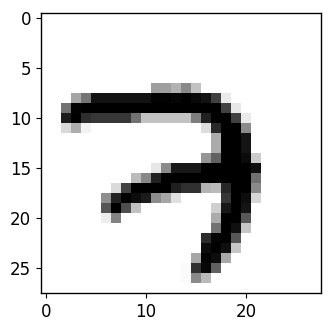

In [3]:
plt.imshow(mnist.train.images[0].reshape(28, 28), cmap='binary')

## Phase 1: Train the autoencoder (unsupervised)

In [4]:
tf.reset_default_graph()

In [5]:
n_inputs = 28 * 28
n_units = 1 * n_inputs // 2
n_outputs = n_inputs

In [6]:
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name="X")
hidden = tf.layers.dense(X, n_units, activation=None, name='over_or_under_complete')
outputs = tf.layers.dense(hidden, n_outputs, activation=None, name='outputs')

In [7]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(reconstruction_loss)

In [8]:
saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [9]:
batch_size = 200
epochs = 10
codings = hidden

In [10]:
ckpt_path = '/tmp/data/overcomplete_to_undercomplete_n_inputs_is_' + str(n_inputs) + '.ckpt'
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch})
          if not (epoch % 2): print epoch, reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     save_path = saver.save(sess, ckpt_path)

0 0.00481374
2 0.00155759
4 0.000862973
6 0.000596635
8 0.000498954
10 0.000435496


In [11]:
X_train = mnist.train.images
y_train = mnist.train.labels
X_test = mnist.test.images
y_test = mnist.test.labels

INFO:tensorflow:Restoring parameters from /tmp/data/overcomplete_to_undercomplete_n_inputs_is_784.ckpt


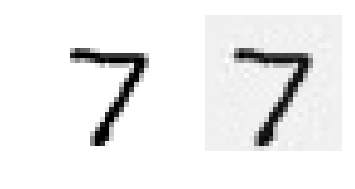

In [12]:
with tf.Session() as sess:
     saver.restore(sess, ckpt_path)
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})
     outputs_test = outputs.eval(feed_dict={X:X_test})
     
     plt.subplot(131)
     plt.imshow(X_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')
     plt.subplot(132)
     #plt.imshow(codings_test[0].reshape(56, 56), cmap='binary'); plt.axis('off')
     #plt.subplot(133)
     plt.imshow(outputs_test[0].reshape(28, 28), cmap='binary'); plt.axis('off')

### Compute the accuracy using the codings of the test set

In [13]:
from sklearn.linear_model import SGDClassifier

SGDClassifier(loss='log', random_state=42, tol=1e-4).fit(codings_train, y_train).score(codings_test, y_test)

0.9173

## Phase 2: Freeze the hidden layer and add a FC layer with softmax

In [14]:
# modify the graph above, no reset here
new_outputs = tf.layers.dense(hidden, units=10, activation=None, name='new_outputs')
y = tf.placeholder(dtype=tf.int32, shape=(None))

In [15]:
train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='new')
train_vars

[<tf.Variable 'new_outputs/kernel:0' shape=(392, 10) dtype=float32_ref>,
 <tf.Variable 'new_outputs/bias:0' shape=(10,) dtype=float32_ref>]

In [16]:
xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=new_outputs)
loss = tf.reduce_mean(xentropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.005, name='Adam2')
training_op = optimizer.minimize(loss, var_list=train_vars)
correct = tf.nn.in_top_k(new_outputs, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()

In [17]:
batch_size = 200
epochs = 30

In [18]:
with tf.Session() as sess:
     init.run()
     saver.restore(sess, ckpt_path) # restore the variable values
     #wts_before = [v for v in tf.trainable_variables() if v.name == "hidden/kernel:0"][0].eval()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, y_batch = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
          if not (epoch % 5): print epoch, accuracy.eval(feed_dict={X:X_test, y:y_test}), loss.eval(feed_dict={X:X_test, y:y_test})
     #wts_after = [v for v in tf.trainable_variables() if v.name == "hidden/kernel:0"][0].eval()

INFO:tensorflow:Restoring parameters from /tmp/data/overcomplete_to_undercomplete_n_inputs_is_784.ckpt
0 0.914 0.311368
5 0.9223 0.275479
10 0.9237 0.269579
15 0.9232 0.269785
20 0.9253 0.270357
25 0.9257 0.273202
30 0.9242 0.279122


| n_inputs | SGDClassifier Accuracy using Codings | Supervised Accuracy |
|---|---|
|2 x 784|91.8|92.1|
|1 x 784|91.7|92.3|
|784 / 2|91.8|92.4|

The results are independent of the number of neurons in the codings layer. The expectation was that the overcomplete autoencoder would lead to less accuracy when reused for the model trained with supervision.

# Part II: Codings accuracy versus number of neurons in hidden layer

Here we try a simpler case. We consider one hidden layer and vary its number of neurons. The accuracy is computed using SDGClassifier on the codings of the test set:

In [105]:
tf.reset_default_graph()

In [106]:
n_inputs = 784
n_units = 2*784
n_outputs = n_inputs

In [107]:
X = tf.placeholder(dtype=tf.float32, shape=(None, n_inputs), name="X")
hidden = tf.layers.dense(X, n_units, activation=None, name='over_or_under_complete')
outputs = tf.layers.dense(hidden, n_outputs, activation=None, name='outputs')

In [108]:
reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_op = optimizer.minimize(reconstruction_loss)

In [109]:
init = tf.global_variables_initializer()

In [110]:
batch_size = 200
epochs = 20
codings = hidden

In [111]:
with tf.Session() as sess:
     init.run()
     for epoch in xrange(epochs + 1):
          for iteration in xrange(mnist.train.num_examples // batch_size):
               X_batch, _ = mnist.train.next_batch(batch_size)
               sess.run(training_op, feed_dict={X:X_batch})
          if not (epoch % 2): print epoch, reconstruction_loss.eval(feed_dict={X:mnist.validation.images})
     codings_train = codings.eval(feed_dict={X:X_train})
     codings_test = codings.eval(feed_dict={X:X_test})

0 0.00116399
2 6.28923e-05
4 7.4095e-05
6 5.52633e-05
8 4.8892e-05
10 3.26859e-05
12 2.87289e-05
14 0.000152808
16 0.000145184
18 7.73767e-05
20 7.27525e-05


In [112]:
sgd_clf = SGDClassifier(loss='log', random_state=42, tol=1e-4, penalty='l2', alpha=0.1)
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.85919999999999996

In [113]:
sgd_clf = SGDClassifier(loss='log', random_state=42, tol=1e-4, penalty='l2', alpha=0.001)
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.91379999999999995

In [114]:
sgd_clf = SGDClassifier(loss='log', random_state=42, tol=1e-4, penalty='l2', alpha=0.0001)
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.91679999999999995

In [115]:
sgd_clf = SGDClassifier(loss='log', random_state=42, tol=1e-4, penalty='l2', alpha=0.00001)
sgd_clf.fit(codings_train, y_train).score(codings_test, y_test)

0.89929999999999999

|neurons in coding layer|reconstruction loss|accuracy|
|---|---|
| 10|0.034|79|
| 25|0.020|87|
| 50|0.012|90|
|100|0.0058|91|
|250|0.0016|91|
|500|0.0001|91|
|784|5e-5|91|
|1568|5e-5|91|

We see that as the number of neurons increases the reconstruction loss and accuracy increase until the two saturate. We note that using about 75 neurons gives the same accuracy as a larger number. This is the value we would choose if we were using the autoencoder for dimensionality reduction.